In [ ]:
import pandas as pd
from google.colab import drive
# Google Colab drive mount
drive.mount('/content/drive')

# Load data from Google Drive
train_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_train.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)
val_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_val.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)

#Technique counts for training set
train_count = train_data['label'].value_counts()

#Technique counts for test
val_count = val_data['label'].value_counts().reindex(train_count.index) #To make sure that the test data the Propaganda Techniques match in both files

#Into dataf
count = pd.DataFrame({'Propaganda Techniques': train_count.index, 'Training Data': train_count.values, 'Test Data': val_count.values})

count


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Propaganda Techniques,Training Data,Test Data
0,not_propaganda,1191,301
1,"exaggeration,minimisation",164,28
2,causal_oversimplification,158,31
3,"name_calling,labeling",157,31
4,loaded_language,154,37
5,appeal_to_fear_prejudice,151,43
6,flag_waving,148,39
7,repetition,147,32
8,doubt,144,38


## Task 1

### Testing LSTM Model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
27/27 - 10s - loss: 0.6845 - accuracy: 0.5447 - val_loss: 0.6735 - val_accuracy: 0.5890 - 10s/epoch - 389ms/step
Epoch 2/10
27/27 - 3s - loss: 0.6244 - accuracy: 0.6507 - val_loss: 0.6433 - val_accuracy: 0.6552 - 3s/epoch - 110ms/step
Epoch 3/10
27/27 - 4s - loss: 0.4159 - accuracy: 0.8348 - val_loss: 0.6288 - val_accuracy: 0.6717 - 4s/epoch - 159ms/step
Epoch 4/10
27/27 - 3s - loss: 0.2288 - accuracy: 0.9278 - val_loss: 0.6607 - val_accuracy: 0.6759 - 3s/epoch - 114ms/step
Epoch 5/10
27/27 - 2s - loss: 0.1393 - accuracy: 0.9645 - val_loss: 0.8192 - val_accuracy: 0.6731 - 2s/epoch - 89ms/step
Epoch 6/10
27/27 - 3s - loss: 0.0761 - accuracy: 0.9828 - val_loss: 1.1872 - val_accuracy: 0.6483 - 3s/epoch - 103ms/step
Epoch 7/10
27/27 - 3s - loss: 0.0479 - accuracy: 0.9876 - val_loss: 1.2485 - val_accuracy: 0.6455 - 3s/epoch - 115ms/step
Epoch 8/10
27/27

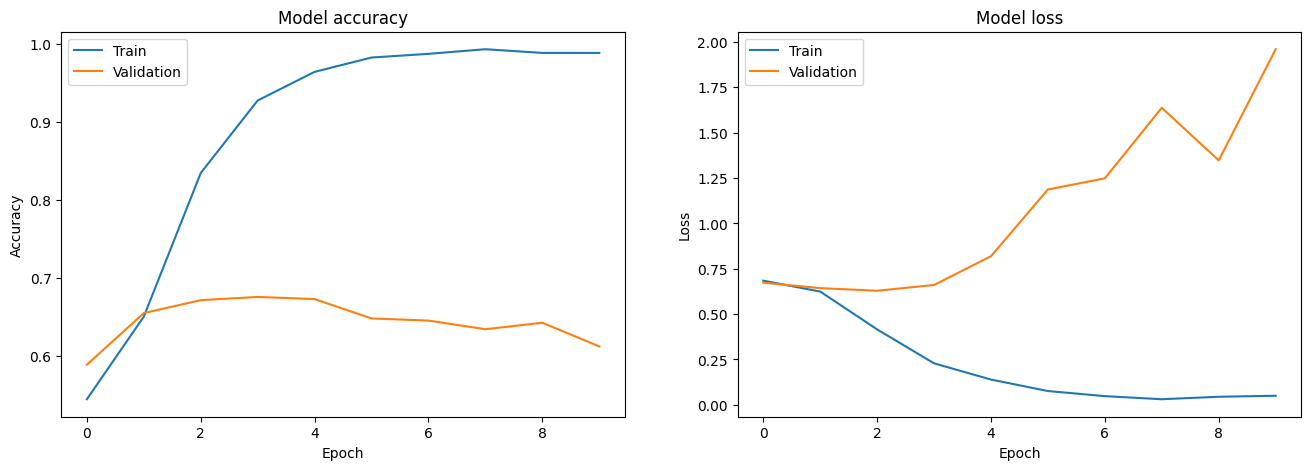

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


from google.colab import drive
# Google Colab drive mount
drive.mount('/content/drive')

#Loads data from Google Drive
train_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_train.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)
val_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_val.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)

#Preprocess data to removing <BOS> and <EOS> tags in the data
def preprocess_data(data):
    data['tagged_in_context'] = data['tagged_in_context'].apply(lambda x: re.sub(r'<BOS>|<EOS>', '', x).strip())
    return data

#Preprocessing the data
train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)

#Convert labels for binary classification
label_mapping_binary = {'not_propaganda': 0, 'flag_waving': 1, 'appeal_to_fear_prejudice': 1, 'causal_oversimplification': 1, 'doubt': 1, 'exaggeration,minimisation': 1, 'loaded_language': 1, 'name_calling,labeling': 1, 'repetition': 1}

train_data['binary_label'] = train_data['label'].map(label_mapping_binary)
val_data['binary_label'] = val_data['label'].map(label_mapping_binary)

#Spliting training data 70/30 for training
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['tagged_in_context'], train_data['binary_label'], test_size=0.3, random_state=1)

#Tokenisation (OOV) and padding
vocab_size = 10000
sequence_length = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(val_data['tagged_in_context'])

train_padded = pad_sequences(train_sequences, maxlen=sequence_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=sequence_length, padding='post', truncating='post')

#Convert labels to numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(val_data['binary_label'])

#Model para
model = Sequential([Embedding(vocab_size, 64, input_length=sequence_length), LSTM(64), Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#Model training
history = model.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels), verbose=2, batch_size=64)

#Model evaluation on test data
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

#Plots the training data
def plot_training_history(history):
    plt.figure(figsize=(16, 5))

    #Plots training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    #Plots training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.show()

plot_training_history(history)


19/19 [==============================] - 1s 10ms/step
      Metric  Non-Propaganda  Propaganda
0  Precision        0.705882    0.596100
1     Recall        0.518272    0.767025
2   F1-Score        0.597701    0.670846


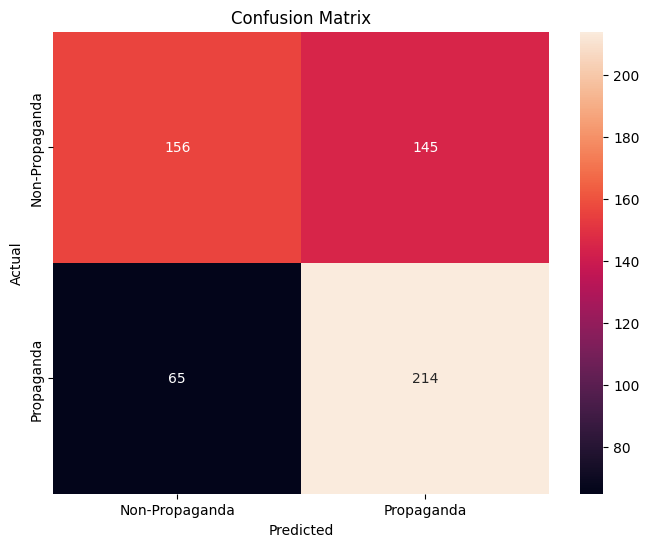

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#ConfusionMatrix class calculating precision, recall, and F1 scores
class ConfusionMatrix:
    def __init__(self, predictions, goldstandard, classes=(1, 0)):
        self.c1, self.c2 = classes
        self.TP = 0
        self.FP = 0
        self.FN = 0
        self.TN = 0
        for p, g in zip(predictions, goldstandard):
            if p == self.c1 and g == self.c1:
                self.TP += 1
            elif p == self.c1 and g == self.c2:
                self.FP += 1
            elif p == self.c2 and g == self.c1:
                self.FN += 1
            elif p == self.c2 and g == self.c2:
                self.TN += 1

    def precision(self):
        if (self.TP + self.FP) == 0:
            return 0
        return self.TP / (self.TP + self.FP)

    def recall(self):
        if (self.TP + self.FN) == 0:
            return 0
        return self.TP / (self.TP + self.FN)

    def f1(self):
        if (self.precision() + self.recall()) == 0:
            return 0
        return 2 * self.precision() * self.recall() / (self.precision() + self.recall())



#Predicts the labels test data
y_pred_test = model.predict(test_padded)
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

#Computes cm and metrics
cm = confusion_matrix(test_labels, y_pred_test)

#Calculates precision, recall, f1
cm_metrics_non_propaganda = ConfusionMatrix(y_pred_test, test_labels, classes=(0, 1))
cm_metrics_propaganda = ConfusionMatrix(y_pred_test, test_labels, classes=(1, 0))

precision_non_propaganda = cm_metrics_non_propaganda.precision()
recall_non_propaganda = cm_metrics_non_propaganda.recall()
f1_score_non_propaganda = cm_metrics_non_propaganda.f1()

precision_propaganda = cm_metrics_propaganda.precision()
recall_propaganda = cm_metrics_propaganda.recall()
f1_score_propaganda = cm_metrics_propaganda.f1()

#display df
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Non-Propaganda': [precision_non_propaganda, recall_non_propaganda, f1_score_non_propaganda],
    'Propaganda': [precision_propaganda, recall_propaganda, f1_score_propaganda]
})

metrics_df.set_index('Metric')

#Prints DataFrame
print(metrics_df)

#Plots the confusion matrix
def plot_cm(cm):
    data = [[cm.TN, cm.FP], [cm.FN, cm.TP]]
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, fmt="d", xticklabels=["Non-Propaganda", "Propaganda"], yticklabels=["Non-Propaganda", "Propaganda"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

#plots cm
cm = ConfusionMatrix(y_pred_test, test_labels)
plot_cm(cm)


### LSTM Model Run 1

Epoch 1/3
85/85 - 7s - loss: 0.6857 - accuracy: 0.5571 - val_loss: 0.6653 - val_accuracy: 0.6000 - 7s/epoch - 88ms/step
Epoch 2/3
85/85 - 3s - loss: 0.6036 - accuracy: 0.6903 - val_loss: 0.6168 - val_accuracy: 0.6593 - 3s/epoch - 32ms/step
Epoch 3/3
85/85 - 3s - loss: 0.3152 - accuracy: 0.8928 - val_loss: 0.6582 - val_accuracy: 0.6841 - 3s/epoch - 32ms/step
19/19 [==============================] - 0s 10ms/step - loss: 0.6171 - accuracy: 0.7017
Test Loss: 0.6171479821205139
Test Accuracy: 0.701724112033844


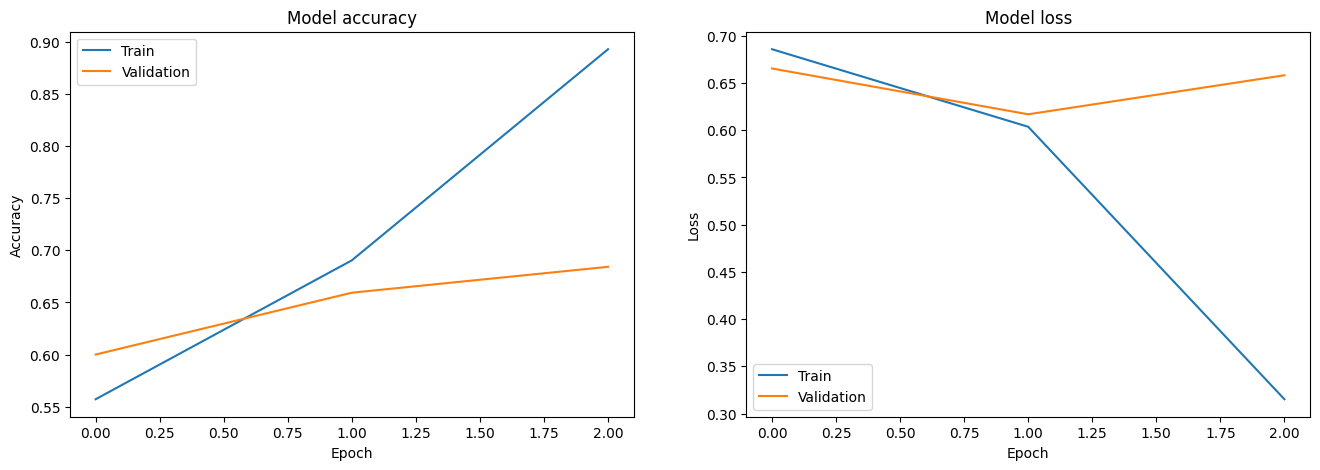

In [ ]:
#Model para
model = Sequential([ Embedding(vocab_size, 64, input_length=sequence_length), LSTM(64), Dropout(0.4), Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#Model training
history = model.fit(train_padded, train_labels, epochs=3, validation_data=(val_padded, val_labels), verbose=2, batch_size=20)

#Model evaluation on test data
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


plot_training_history(history)

19/19 [==============================] - 1s 9ms/step
      Metric  Non-Propaganda  Propaganda
0  Precision        0.671123    0.757282
1     Recall        0.833887    0.559140
2   F1-Score        0.743704    0.643299


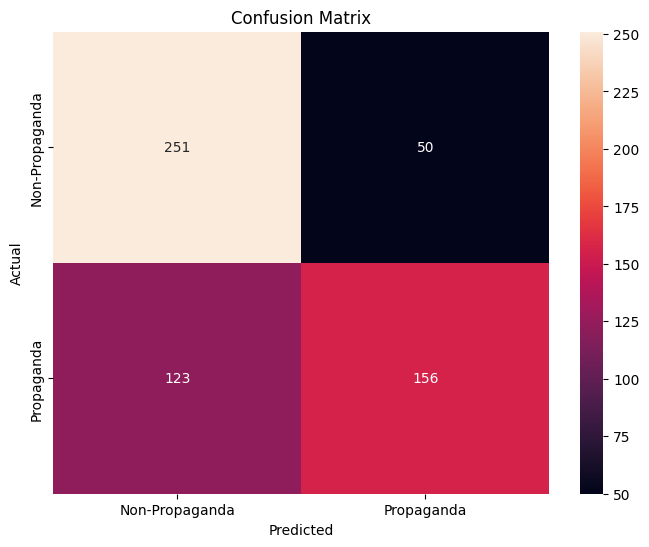

In [ ]:
#Predicts the labels
y_pred_test = model.predict(test_padded)
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

#Computes cm and metrics
cm = confusion_matrix(test_labels, y_pred_test)

#Calculates precision, recall, and f1
cm_metrics_non_propaganda = ConfusionMatrix(y_pred_test, test_labels, classes=(0, 1))
cm_metrics_propaganda = ConfusionMatrix(y_pred_test, test_labels, classes=(1, 0))

precision_non_propaganda = cm_metrics_non_propaganda.precision()
recall_non_propaganda = cm_metrics_non_propaganda.recall()
f1_score_non_propaganda = cm_metrics_non_propaganda.f1()

precision_propaganda = cm_metrics_propaganda.precision()
recall_propaganda = cm_metrics_propaganda.recall()
f1_score_propaganda = cm_metrics_propaganda.f1()

#display df
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Non-Propaganda': [precision_non_propaganda, recall_non_propaganda, f1_score_non_propaganda],
    'Propaganda': [precision_propaganda, recall_propaganda, f1_score_propaganda]
})

metrics_df.set_index('Metric')

#Prints DataFrame
print(metrics_df)

#plots cm
cm = ConfusionMatrix(y_pred_test, test_labels)
plot_cm(cm)

### LSTM Model Run 2

Epoch 1/3
85/85 - 8s - loss: 0.6792 - accuracy: 0.5554 - val_loss: 0.6628 - val_accuracy: 0.6083 - 8s/epoch - 96ms/step
Epoch 2/3
85/85 - 3s - loss: 0.5997 - accuracy: 0.7010 - val_loss: 0.6190 - val_accuracy: 0.6593 - 3s/epoch - 35ms/step
Epoch 3/3
85/85 - 3s - loss: 0.3618 - accuracy: 0.8727 - val_loss: 0.6360 - val_accuracy: 0.6828 - 3s/epoch - 35ms/step
19/19 [==============================] - 0s 10ms/step - loss: 0.5842 - accuracy: 0.6948
Test Loss: 0.5842361450195312
Test Accuracy: 0.6948275566101074


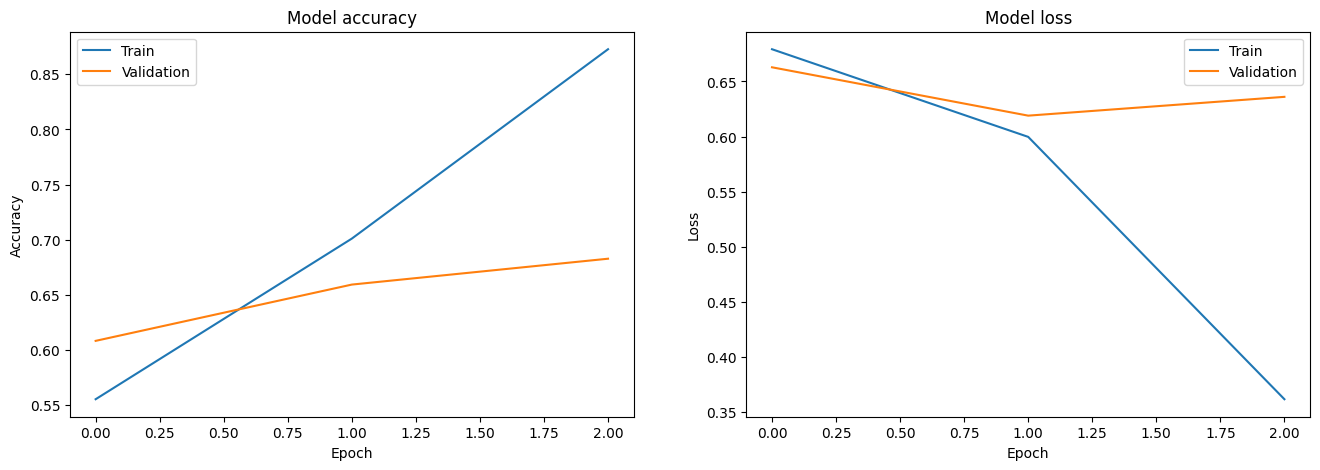

In [ ]:
#Model para
model = Sequential([ Embedding(vocab_size, 64, input_length=sequence_length), LSTM(64), Dropout(0.4), Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#Model training
history = model.fit(train_padded, train_labels, epochs=3, validation_data=(val_padded, val_labels), verbose=2, batch_size=20)

#Model evaluation on test data
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

plot_training_history(history)

19/19 [==============================] - 1s 10ms/step
      Metric  Non-Propaganda  Propaganda
0  Precision        0.691358    0.699219
1     Recall        0.744186    0.641577
2   F1-Score        0.716800    0.669159


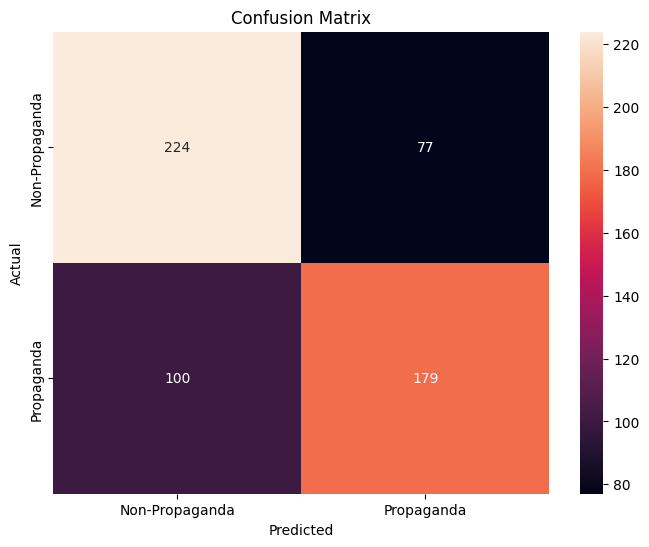

In [ ]:
#Predicts the labels
y_pred_test = model.predict(test_padded)
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

#Computes cm and metrics
cm = confusion_matrix(test_labels, y_pred_test)

#Calculatea precision, recall, and f1
cm_metrics_non_propaganda = ConfusionMatrix(y_pred_test, test_labels, classes=(0, 1))
cm_metrics_propaganda = ConfusionMatrix(y_pred_test, test_labels, classes=(1, 0))

precision_non_propaganda = cm_metrics_non_propaganda.precision()
recall_non_propaganda = cm_metrics_non_propaganda.recall()
f1_score_non_propaganda = cm_metrics_non_propaganda.f1()

precision_propaganda = cm_metrics_propaganda.precision()
recall_propaganda = cm_metrics_propaganda.recall()
f1_score_propaganda = cm_metrics_propaganda.f1()

#display df
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Non-Propaganda': [precision_non_propaganda, recall_non_propaganda, f1_score_non_propaganda],
    'Propaganda': [precision_propaganda, recall_propaganda, f1_score_propaganda]
})

metrics_df.set_index('Metric')

#Prints df
print(metrics_df)

#plots cm
cm = ConfusionMatrix(y_pred_test, test_labels)
plot_cm(cm)

### BoW

In [ ]:
#SVM
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, hinge_loss, confusion_matrix

#Vectorisation(CountVectorizer)
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(train_texts)
X_val_bow = vectorizer.transform(val_texts)
X_test_bow = vectorizer.transform(val_data['tagged_in_context'])

#Trains SVC
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train_bow, train_labels)

#Evaluation
val_preds = svc.predict(X_val_bow)
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy}")

#Evaluation test d
test_preds = svc.predict(X_test_bow)
test_accuracy = accuracy_score(val_data['binary_label'], test_preds)
print(f"Test Accuracy: {test_accuracy}")

#Calculates loss test data
test_loss = hinge_loss(val_data['binary_label'], svc.decision_function(X_test_bow))
print(f"Test Loss: {test_loss}")


Validation Accuracy: 0.6386206896551724
Test Accuracy: 0.653448275862069
Test Loss: 0.7791555691279993


           Non-Propaganda  Propaganda
Metric                               
Precision        0.653374    0.653543
Recall           0.707641    0.594982
F1-Score         0.679426    0.622889


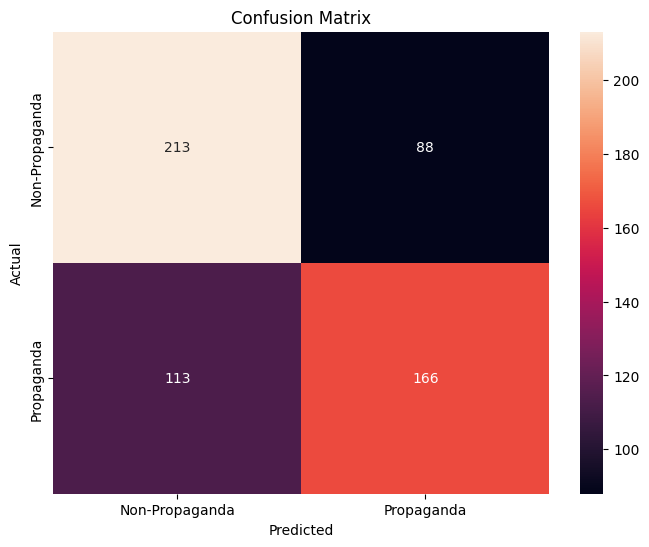

In [ ]:
#cm and metrics calculation
cm_bow = confusion_matrix(val_data['binary_label'], test_preds)

#cm class for calculate metrics
cm_metrics_non_propaganda = ConfusionMatrix(test_preds, val_data['binary_label'], classes=(0, 1))
cm_metrics_propaganda = ConfusionMatrix(test_preds, val_data['binary_label'], classes=(1, 0))

precision_non_propaganda = cm_metrics_non_propaganda.precision()
recall_non_propaganda = cm_metrics_non_propaganda.recall()
f1_score_non_propaganda = cm_metrics_non_propaganda.f1()

precision_propaganda = cm_metrics_propaganda.precision()
recall_propaganda = cm_metrics_propaganda.recall()
f1_score_propaganda = cm_metrics_propaganda.f1()

#display df
metrics_df_svc = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Non-Propaganda': [precision_non_propaganda, recall_non_propaganda, f1_score_non_propaganda],
    'Propaganda': [precision_propaganda, recall_propaganda, f1_score_propaganda]
})

metrics_df_svc.set_index('Metric', inplace=True)
print(metrics_df_svc)

#plots cm graph
def plot_cm(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Non-Propaganda", "Propaganda"], yticklabels=["Non-Propaganda", "Propaganda"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

#Plot cm
plot_cm(cm_bow)


## Task 2

### Testing LSTM Model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/15
85/85 - 6s - loss: 1.8252 - accuracy: 0.4819 - val_loss: 1.7491 - val_accuracy: 0.4979 - 6s/epoch - 69ms/step
Epoch 2/15
85/85 - 4s - loss: 1.7325 - accuracy: 0.4920 - val_loss: 1.7325 - val_accuracy: 0.5062 - 4s/epoch - 41ms/step
Epoch 3/15
85/85 - 3s - loss: 1.5546 - accuracy: 0.5198 - val_loss: 1.6124 - val_accuracy: 0.4883 - 3s/epoch - 30ms/step
Epoch 4/15
85/85 - 3s - loss: 1.3509 - accuracy: 0.5335 - val_loss: 1.6309 - val_accuracy: 0.4966 - 3s/epoch - 30ms/step
Epoch 5/15
85/85 - 3s - loss: 1.1931 - accuracy: 0.5577 - val_loss: 1.7821 - val_accuracy: 0.4662 - 3s/epoch - 40ms/step
Epoch 6/15
85/85 - 7s - loss: 1.1400 - accuracy: 0.5601 - val_loss: 1.8611 - val_accuracy: 0.5007 - 7s/epoch - 78ms/step
Epoch 7/15
85/85 - 6s - loss: 1.0784 - accuracy: 0.5696 - val_loss: 1.8869 - val_accuracy: 0.4993 - 6s/epoch - 65ms/step
Epoch 8/15
85/85 - 5s - 

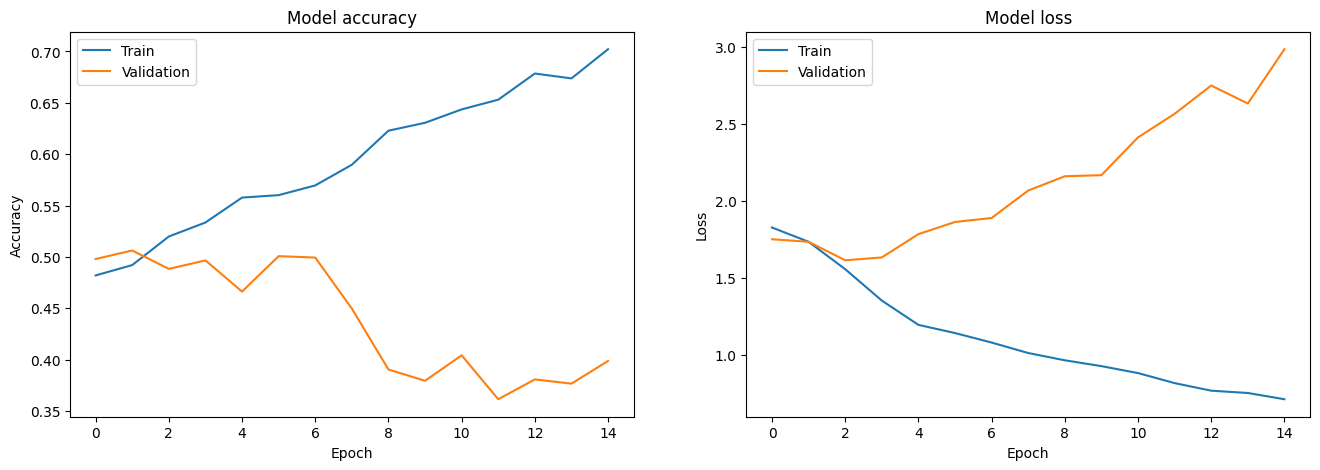

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


from google.colab import drive
# Google Colab drive mount
drive.mount('/content/drive')

#Load data from Google Drive
train_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_train.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)
val_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_val.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)

#Preprocess data to extract words between the tags
def preprocess_data(data):
    snippets = []
    for sentence in data['tagged_in_context']:
        #Extract text between tags
        snippet = re.search(r'<BOS>(.*?)<EOS>', sentence).group(1).strip()
        snippets.append(snippet)
    data['tagged_in_context'] = snippets
    return data

#Preprocessing the data
train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)

#Labels for multi-class classification
label_mapping_multiclass = {'not_propaganda': 0, 'flag_waving': 1, 'appeal_to_fear_prejudice': 2, 'causal_oversimplification': 3, 'doubt': 4, 'exaggeration,minimisation': 5, 'loaded_language': 6, 'name_calling,labeling': 7,  'repetition': 8}


train_data['multiclass_label'] = train_data['label'].map(label_mapping_multiclass)
val_data['multiclass_label'] = val_data['label'].map(label_mapping_multiclass)

#Spliting training data 70/30 for training
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['tagged_in_context'], train_data['multiclass_label'], test_size=0.3, random_state=1)


#Tokenisation (OOV) and padding
vocab_size = 10000
sequence_length = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(val_data['tagged_in_context'])

train_padded = pad_sequences(train_sequences, maxlen=sequence_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=sequence_length, padding='post', truncating='post')

#Convert labels to class format
train_labels_split = to_categorical(train_labels, num_classes=9)
val_labels_split = to_categorical(val_labels, num_classes=9)
test_labels_split = to_categorical(val_data['multiclass_label'], num_classes=9)

#Model para
model = Sequential([
    Embedding(vocab_size, 64, input_length=sequence_length), LSTM(64), Dropout(0.4), Dense(9, activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#training
history = model.fit(train_padded, train_labels_split, epochs=15, validation_data=(val_padded, val_labels_split), verbose=2, batch_size=20)

#Evaluation of the model
test_loss, test_accuracy = model.evaluate(test_padded, test_labels_split)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#Plot Graph
def plot_training_history(history):
    plt.figure(figsize=(16, 5))

    #Training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    #Training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.show()

plot_training_history(history)



19/19 [==============================] - 1s 19ms/step
                           Precision    Recall  F1-Score
not_propaganda              0.682432  0.671096  0.676717
flag_waving                 0.000000  0.000000  0.000000
appeal_to_fear_prejudice    0.000000  0.000000  0.000000
causal_oversimplification   0.400000  0.258065  0.313725
doubt                       0.224138  0.342105  0.270833
exaggeration,minimisation   0.042105  0.142857  0.065041
loaded_language             0.181818  0.054054  0.083333
name_calling,labeling       0.127273  0.225806  0.162791
repetition                  0.111111  0.156250  0.129870


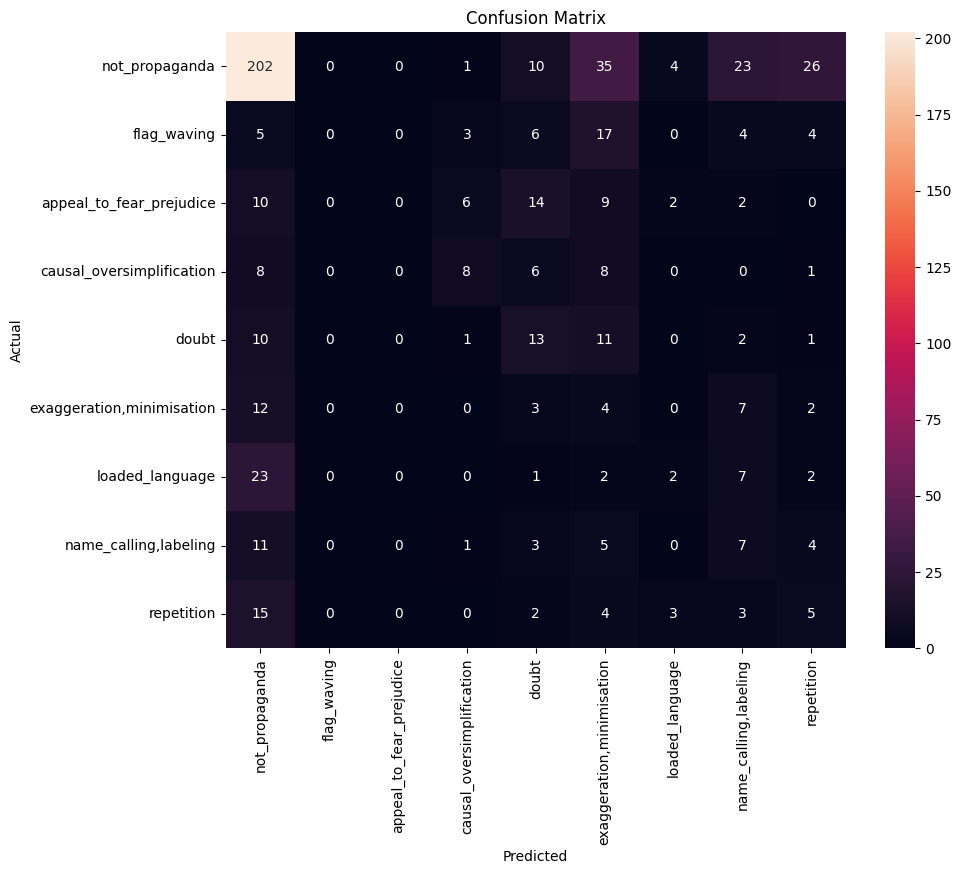

In [ ]:
#ConfusionMatrix class calculating precision, recall, and F1 scores
class ConfusionMatrix:
    def __init__(self, predictions, goldstandard, positive_class):
        self.positive_class = positive_class
        self.TP = 0
        self.FP = 0
        self.FN = 0
        self.TN = 0
        for p, g in zip(predictions, goldstandard):
            if g == self.positive_class:
                if p == self.positive_class:
                    self.TP += 1
                else:
                    self.FN += 1
            elif p == self.positive_class:
                self.FP += 1
            else:
                self.TN += 1

    def precision(self):
        if (self.TP + self.FP) == 0:
            return 0
        return self.TP / (self.TP + self.FP)

    def recall(self):
        if (self.TP + self.FN) == 0:
            return 0
        return self.TP / (self.TP + self.FN)

    def f1(self):
        if (self.precision() + self.recall()) == 0:
            return 0
        return 2 * self.precision() * self.recall() / (self.precision() + self.recall())

#Plot cm
def plot_cm(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=list(label_mapping_multiclass.keys()), yticklabels=list(label_mapping_multiclass.keys()))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

#Predict labels on test data
y_pred_test = model.predict(test_padded)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#Computes metrics for each class
metrics = []
for i in range(9):
    cm_class = ConfusionMatrix(y_pred_test_classes, val_data['multiclass_label'], positive_class=i)
    precision = cm_class.precision()
    recall = cm_class.recall()
    f1_score = cm_class.f1()
    metrics.append([precision, recall, f1_score])

#Display DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-Score'], index=list(label_mapping_multiclass.keys()))

#DataFrame
print(metrics_df)

#Plot confusion matrix
cm = confusion_matrix(val_data['multiclass_label'], y_pred_test_classes)
plot_cm(cm)

###LSTM Model Run 1

Epoch 1/10
169/169 - 43s - loss: 1.8084 - accuracy: 0.4819 - val_loss: 1.7628 - val_accuracy: 0.4966 - 43s/epoch - 257ms/step
Epoch 2/10
169/169 - 43s - loss: 1.7689 - accuracy: 0.4920 - val_loss: 1.7698 - val_accuracy: 0.4966 - 43s/epoch - 255ms/step
Epoch 3/10
169/169 - 27s - loss: 1.7821 - accuracy: 0.4926 - val_loss: 1.7476 - val_accuracy: 0.4966 - 27s/epoch - 157ms/step
Epoch 4/10
169/169 - 33s - loss: 1.7701 - accuracy: 0.4920 - val_loss: 1.7728 - val_accuracy: 0.4966 - 33s/epoch - 197ms/step
Epoch 5/10
169/169 - 29s - loss: 1.7710 - accuracy: 0.4926 - val_loss: 1.7519 - val_accuracy: 0.4966 - 29s/epoch - 172ms/step
Epoch 6/10
169/169 - 38s - loss: 1.7695 - accuracy: 0.4920 - val_loss: 1.7452 - val_accuracy: 0.4966 - 38s/epoch - 227ms/step
Epoch 7/10
169/169 - 27s - loss: 1.7717 - accuracy: 0.4932 - val_loss: 1.7527 - val_accuracy: 0.4966 - 27s/epoch - 160ms/step
Epoch 8/10
169/169 - 31s - loss: 1.9065 - accuracy: 0.4713 - val_loss: 1.7595 - val_accuracy: 0.4966 - 31s/epoch - 182

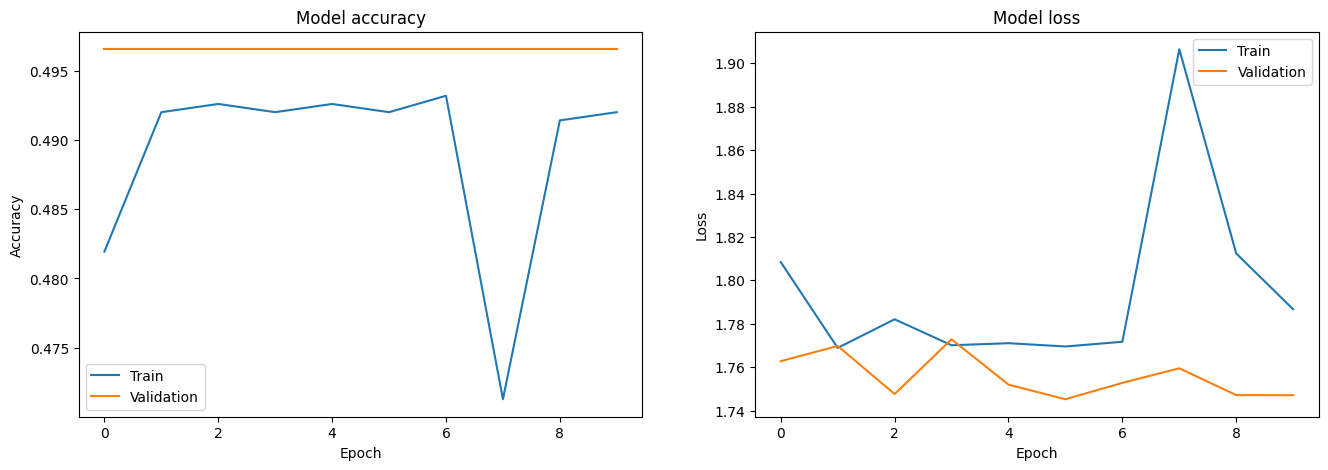

In [ ]:
#Loads data
train_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_train.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)
val_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_val.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)


#Preprocessing the data
train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)


train_data['multiclass_label'] = train_data['label'].map(label_mapping_multiclass)
val_data['multiclass_label'] = val_data['label'].map(label_mapping_multiclass)

#Spliting training data 70/30 for training
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['tagged_in_context'], train_data['multiclass_label'], test_size=0.3, random_state=1)

#Tokenisation (OOV) and padding
vocab_size = 10000
sequence_length = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(val_data['tagged_in_context'])

train_padded = pad_sequences(train_sequences, maxlen=sequence_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=sequence_length, padding='post', truncating='post')

#Convert labels to class format
train_labels_split = to_categorical(train_labels, num_classes=9)
val_labels_split = to_categorical(val_labels, num_classes=9)
test_labels_split = to_categorical(val_data['multiclass_label'], num_classes=9)

#Mode para
model = Sequential([Embedding(vocab_size, 128, input_length=sequence_length), LSTM(128, return_sequences=True), LSTM(64), Dropout(0.4), Dense(9, activation='softmax')])

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#Training
history = model.fit(train_padded, train_labels_split, epochs=10, validation_data=(val_padded, val_labels_split), verbose=2, batch_size=10)

#Evaluation of the model
test_loss, test_accuracy = model.evaluate(test_padded, test_labels_split)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#Plotting graph
plot_training_history(history)




19/19 [==============================] - 3s 92ms/step
                           Precision  Recall  F1-Score
not_propaganda              0.518966     1.0  0.683314
flag_waving                 0.000000     0.0  0.000000
appeal_to_fear_prejudice    0.000000     0.0  0.000000
causal_oversimplification   0.000000     0.0  0.000000
doubt                       0.000000     0.0  0.000000
exaggeration,minimisation   0.000000     0.0  0.000000
loaded_language             0.000000     0.0  0.000000
name_calling,labeling       0.000000     0.0  0.000000
repetition                  0.000000     0.0  0.000000


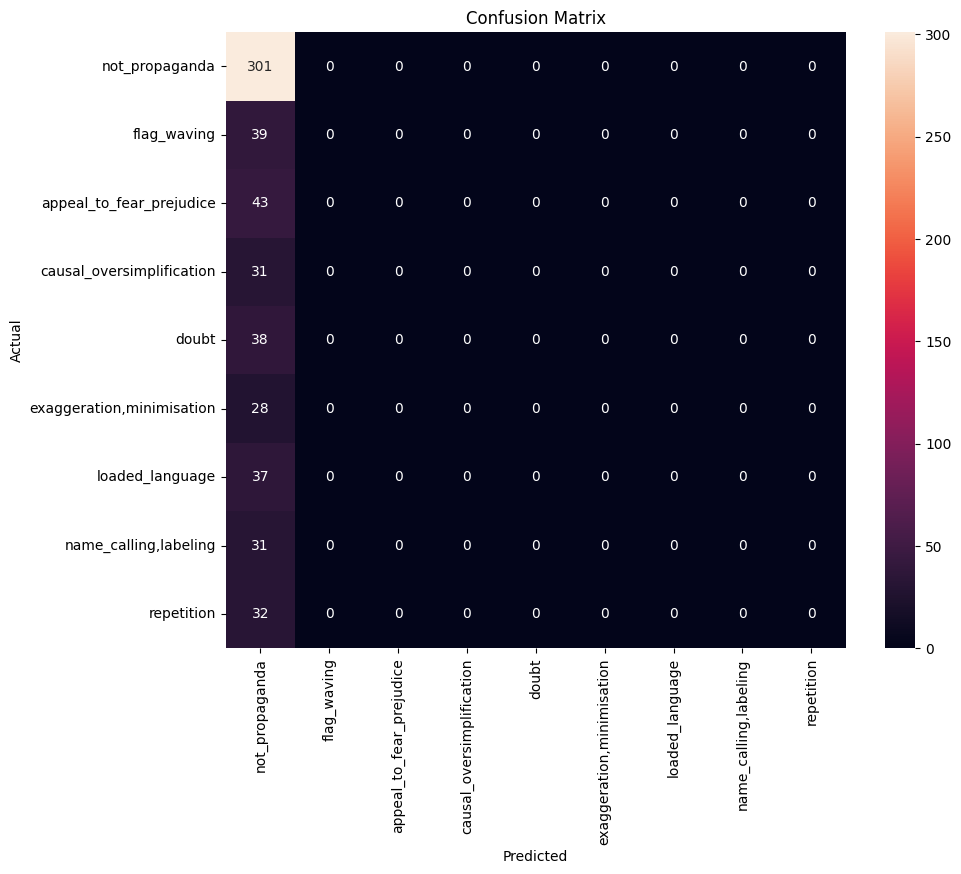

In [ ]:
#Predicts labels on test data
y_pred_test = model.predict(test_padded)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#Computes metrics for each class
metrics = []
for i in range(9):
    cm_class = ConfusionMatrix(y_pred_test_classes, val_data['multiclass_label'], positive_class=i)
    precision = cm_class.precision()
    recall = cm_class.recall()
    f1_score = cm_class.f1()
    metrics.append([precision, recall, f1_score])

#Display DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-Score'], index=list(label_mapping_multiclass.keys()))

#Prints DataFrame
print(metrics_df)

#Computes and plot cm
cm = confusion_matrix(val_data['multiclass_label'], y_pred_test_classes)
plot_cm(cm)

### LSTM Model Run 2

Epoch 1/10
169/169 - 33s - loss: 1.7977 - accuracy: 0.4867 - val_loss: 1.7592 - val_accuracy: 0.4966 - 33s/epoch - 194ms/step
Epoch 2/10
169/169 - 28s - loss: 1.7814 - accuracy: 0.4920 - val_loss: 1.7505 - val_accuracy: 0.4966 - 28s/epoch - 165ms/step
Epoch 3/10
169/169 - 26s - loss: 1.7805 - accuracy: 0.4926 - val_loss: 1.7498 - val_accuracy: 0.4966 - 26s/epoch - 152ms/step
Epoch 4/10
169/169 - 29s - loss: 1.8547 - accuracy: 0.4760 - val_loss: 1.7697 - val_accuracy: 0.4966 - 29s/epoch - 170ms/step
Epoch 5/10
169/169 - 29s - loss: 1.7997 - accuracy: 0.4920 - val_loss: 1.7469 - val_accuracy: 0.4966 - 29s/epoch - 173ms/step
Epoch 6/10
169/169 - 27s - loss: 1.8049 - accuracy: 0.4920 - val_loss: 1.7498 - val_accuracy: 0.4966 - 27s/epoch - 160ms/step
Epoch 7/10
169/169 - 27s - loss: 1.7907 - accuracy: 0.4920 - val_loss: 1.7508 - val_accuracy: 0.4966 - 27s/epoch - 162ms/step
Epoch 8/10
169/169 - 28s - loss: 1.7857 - accuracy: 0.4920 - val_loss: 1.7543 - val_accuracy: 0.4966 - 28s/epoch - 166

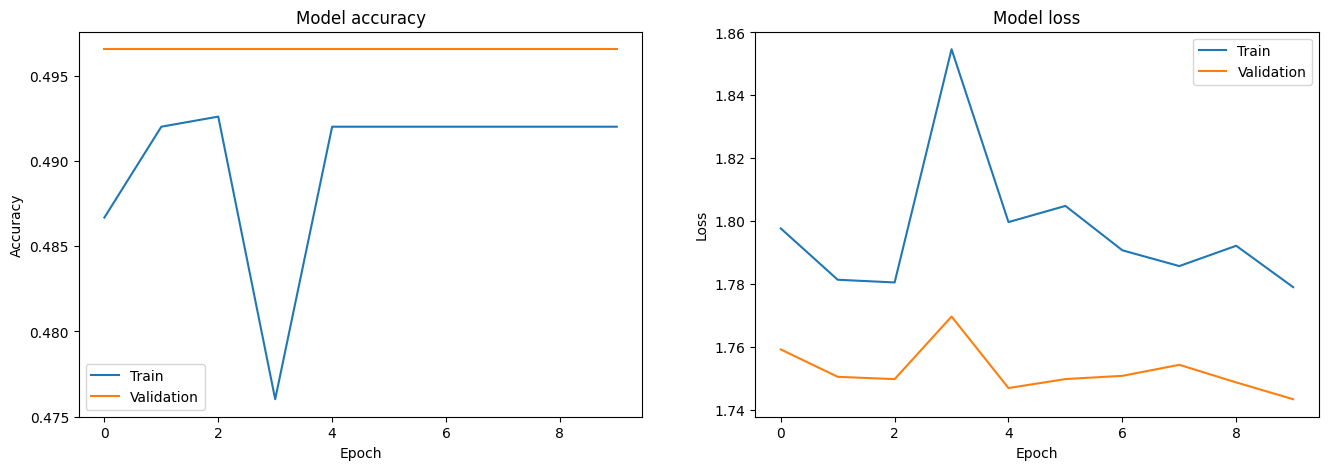

In [ ]:
#Model para
model = Sequential([Embedding(vocab_size, 128, input_length=sequence_length), LSTM(128, return_sequences=True), LSTM(64), Dropout(0.4), Dense(9, activation='softmax')])


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#Model training
history = model.fit(train_padded, train_labels_split, epochs=10, validation_data=(val_padded, val_labels_split), verbose=2, batch_size=10)

#Evaluates the model on test data
test_loss, test_accuracy = model.evaluate(test_padded, test_labels_split)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#Plotting the training graph
plot_training_history(history)

19/19 [==============================] - 2s 59ms/step
                           Precision  Recall  F1-Score
not_propaganda              0.518966     1.0  0.683314
flag_waving                 0.000000     0.0  0.000000
appeal_to_fear_prejudice    0.000000     0.0  0.000000
causal_oversimplification   0.000000     0.0  0.000000
doubt                       0.000000     0.0  0.000000
exaggeration,minimisation   0.000000     0.0  0.000000
loaded_language             0.000000     0.0  0.000000
name_calling,labeling       0.000000     0.0  0.000000
repetition                  0.000000     0.0  0.000000


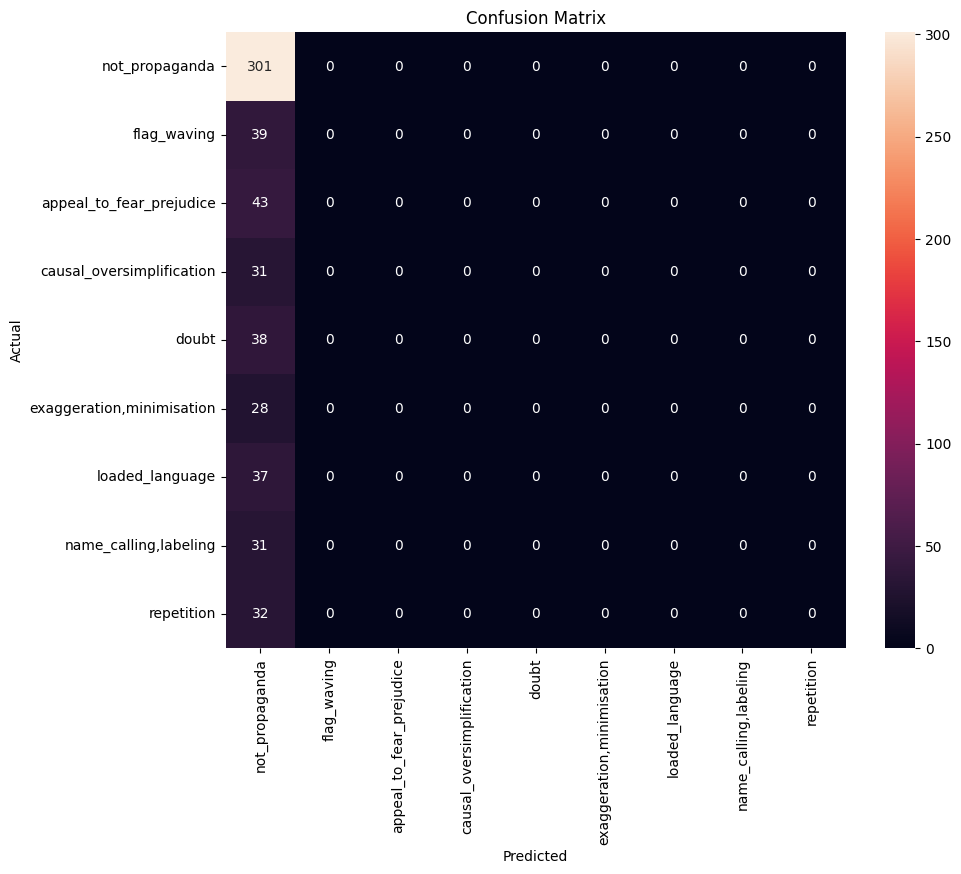

In [ ]:
#Predicts labels on test data
y_pred_test = model.predict(test_padded)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

#Computes metrics for each class
metrics = []
for i in range(9):
    cm_class = ConfusionMatrix(y_pred_test_classes, val_data['multiclass_label'], positive_class=i)
    precision = cm_class.precision()
    recall = cm_class.recall()
    f1_score = cm_class.f1()
    metrics.append([precision, recall, f1_score])

#Display DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-Score'], index=list(label_mapping_multiclass.keys()))

#Prints DataFrame
print(metrics_df)

#Computes and plots cm
cm = confusion_matrix(val_data['multiclass_label'], y_pred_test_classes)
plot_cm(cm)

###BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, hinge_loss


#Loads data from Google Drive
train_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_train.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)
val_data = pd.read_csv('/content/drive/MyDrive/1.1  Advanced Natural Language Processing/Assignment /propaganda_dataset_v2/propaganda_val.tsv', sep='\t', names=["label", "tagged_in_context"], skiprows=1)


#Preprocessing the data
train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)

#Convert labels for multi-class classification
label_mapping_multiclass = {'not_propaganda': 0, 'flag_waving': 1, 'appeal_to_fear_prejudice': 2, 'causal_oversimplification': 3, 'doubt': 4, 'exaggeration,minimisation': 5, 'loaded_language': 6, 'name_calling,labeling': 7,  'repetition': 8}

train_data['multiclass_label'] = train_data['label'].map(label_mapping_multiclass)
val_data['multiclass_label'] = val_data['label'].map(label_mapping_multiclass)

#Spliting training data 70/30 for training
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['tagged_in_context'], train_data['multiclass_label'], test_size=0.3, random_state=1)

#Vectorisation using CountVectorizer
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(train_texts)
X_val_bow = vectorizer.transform(val_texts)
X_test_bow = vectorizer.transform(val_data['tagged_in_context'])

#Train SVC
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train_bow, train_labels)

#Evaluats the model on validation
val_preds = svc.predict(X_val_bow)
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy}")


#Evaluates the model on test data
test_preds = svc.predict(X_test_bow)
test_accuracy = accuracy_score(val_data['multiclass_label'], test_preds)
print(f"Test Accuracy: {test_accuracy}")

#Calculate loss for test data
test_loss = hinge_loss(val_data['multiclass_label'], svc.decision_function(X_test_bow))
print(f"Test Loss: {test_loss}")



Validation Accuracy: 0.5668965517241379
Test Accuracy: 0.5810344827586207
Test Loss: 1.4882582563665547


                           Precision    Recall  F1-Score
not_propaganda              0.635294  0.897010  0.743802
flag_waving                 0.558824  0.487179  0.520548
appeal_to_fear_prejudice    0.384615  0.232558  0.289855
causal_oversimplification   0.400000  0.451613  0.424242
doubt                       0.260870  0.157895  0.196721
exaggeration,minimisation   0.500000  0.142857  0.222222
loaded_language             0.428571  0.081081  0.136364
name_calling,labeling       0.500000  0.129032  0.205128
repetition                  0.500000  0.218750  0.304348


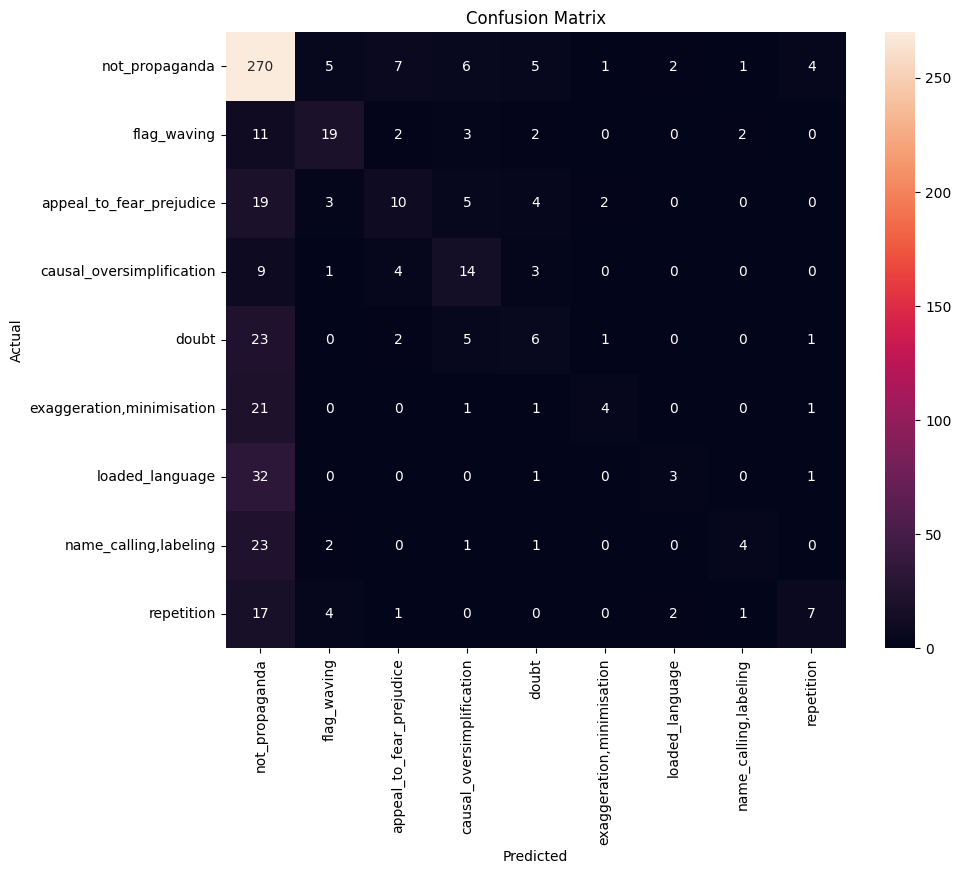

In [ ]:
#Computes metrics
metrics = []
for i in range(9):
    cm_class = ConfusionMatrix(test_preds, val_data['multiclass_label'], positive_class=i)
    precision = cm_class.precision()
    recall = cm_class.recall()
    f1_score = cm_class.f1()
    metrics.append([precision, recall, f1_score])

#Display DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-Score'], index=list(label_mapping_multiclass.keys()))

#Prints DataFrame
print(metrics_df)

#Computes cm for BoW
cm_bow = confusion_matrix(val_data['multiclass_label'], test_preds)

#Plots cm
plot_cm(cm_bow)

# Reference

LSTM

* https://www.kaggle.com/code/rajmehra03/a-complete-text-classfication-guide-word2vec-lstm
* https://www.tensorflow.org/text/tutorials/text_classification_rnn
* https://www.geeksforgeeks.org/training-of-recurrent-neural-networks-rnn-in-tensorflow/
* https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
* https://www.tensorflow.org/guide/keras/understanding_masking_and_padding


BoW
* https://medium.com/@d111gent/step-by-step-bow-text-classification-a-beginners-guide-to-python-text-analysis-813a91592056
* https://priyansh-kedia.medium.com/create-simple-bag-of-words-models-78b19578246
* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html